In [ ]:
#the difference between version 1 and 2 is that version 2 considers only 1 year before and after 

In [1]:
import pandas as pd
import os
import json
import csv
import re, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date, timedelta
from lifelines.statistics import logrank_test
from lifelines import KaplanMeierFitter
import ast
from datetime import datetime

from global_functions import *

In [2]:
release_creation_ts_all = get_release_dates()

yearly_releases = get_yearly_releases()

release_creation_ts_rolling = get_rolling_releases()
rolling_releases=get_rolling_releases()

In [3]:
def version_successor(release):
    if release=='4.8':
        return '4.9'
    return yearly_releases[yearly_releases.index(release)+1]
def version_successor_rolling(release):
    if release=='4.10':
        return '4.11'
    return rolling_releases[rolling_releases.index(release)+1]
   
def version_predecessor(release):
    return yearly_releases[yearly_releases.index(release)-1]    
     
    

In [4]:
def attach_severity_priority_to_dataframe(df):
    sev_info = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_full.csv',index_col=False,
                      dtype={'version':str})
    sev_info = sev_info[['id','severity','priority']]

    df = pd.merge(df,sev_info,on=['id'],how='left')
    return df


In [5]:
#Load data
df_all = pd.read_csv('.'+os.sep+'data'+os.sep+'bugs_info.csv',index_col=False,dtype={'release':str,'version':str})
df_all = df_all.fillna('')
df_all = trans_to_datetime(df_all,['creation_time','first_assignment_date','last_assignment_date',
                          'first_resolved_date','last_resolved_date',
                           'first_fixed_date','last_fixed_date'])
df_all=attach_severity_priority_to_dataframe(df_all)
df_all.head(n=2)

C:\Users\zeinab\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3185: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,id,release,Product,creation_time,version,resolution,is_assigned,is_resolved,is_fixed,first_assignment_date,...,last_fixed_date,time_assign_diff,time_resolve_diff,time_fix_diff,min_release,max_release,min_release_before_version_field,min_release_after_version_field,severity,priority
0,475361,4.5,Platform,2015-08-19 10:50:25,4.5,FIXED,0,1,1,NaT,...,2015-08-19 11:53:03,,0,0,4.5,4.5,False,False,normal,P3
1,475365,4.6,Platform,2015-08-19 11:34:37,4.6,FIXED,0,1,1,NaT,...,2015-08-26 14:29:30,,0,0,4.6,4.6,False,False,minor,P3


In [41]:
#all expect these in rolling releases
df=df_all[(df_all['release']!='4.9') & (df_all['release']!='4.10')]
#bugs in rolling release
df_rolling=df_all[(df_all['release']=='4.9') | (df_all['release']=='4.10')]

In [42]:
def get_triaging_statistics_per_release(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        resolve_column = 'first_resolved_date'
    else:
        resolve_column = 'last_resolved_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        if version=='3.0':
            end_date_before=addYears(start_date,-1)
            #print(release_creation_ts_all[version_successor(version)])
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')
        else:
            end_date_before=datetime.strptime(release_creation_ts_all[version_predecessor(version)], '%Y-%m-%d %H:%M:%S')
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')                
        
        #print('version: ',version, 'start_date: ',start_date,'end_date_before: ',end_date_before,'end_date_after: ',end_date_after)

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column] >= start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0)  &  (version_bugs[assingment_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0) &  (version_bugs[assingment_column] > end_date_after )]
        )

 #& (version_bugs[assingment_column] < end_date_after)
     
        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA =  bugs_created_before_assigned_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        RANA = bugs_created_after_release_not_assigned.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)
    return df_ret

In [43]:
tfile = 'data'+os.sep+'RQ2'+os.sep+'year_releases_yearly_stats_first_assign-v2.csv'

if not os.path.exists(tfile):
    df_yearly_stats_first = get_triaging_statistics_per_release(df,assignedFirst=True,resolvedFirst=False)
    df_yearly_stats_first.to_csv(tfile,index=False)
else:
    df_yearly_stats_first = pd.read_csv(tfile,index_col=False,
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first["RAAA"]  = df_yearly_stats_first["RAAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAA"]  = df_yearly_stats_first["RBAA"].apply(ast.literal_eval)
    df_yearly_stats_first["RBAB"]  = df_yearly_stats_first["RBAB"].apply(ast.literal_eval)
    df_yearly_stats_first["RANA"]  = df_yearly_stats_first["RANA"].apply(ast.literal_eval)
    
df_yearly_stats_first['version'] = df_yearly_stats_first['version'].astype(str)
df_yearly_stats_first = sort_df(df_yearly_stats_first,'version')
df_yearly_stats_first.head()

,version,RAAA,RANA,RBAA,RBAB,after_release,before_release,total
0,3.0,"[101046, 101423, 101428, 101447, 101634, 82564...","[101500, 101894, 82801, 82863, 83375, 83496, 8...","[64613, 64643, 64682, 64686, 64707, 64742, 647...","[64617, 64621, 64626, 64627, 64628, 64629, 646...",6534.0,17758.0,24937.0
1,3.1,"[101968, 102001, 102019, 102033, 102081, 10208...","[102297, 102570, 102584, 102813, 102879, 10288...","[100816, 100835, 100843, 100845, 100853, 10086...","[100814, 100822, 100825, 100826, 100829, 10088...",5264.0,12168.0,17908.0
2,3.2,"[183822, 184304, 184932, 185556, 185668, 18574...","[183675, 183922, 184345, 184413, 184933, 18521...","[103650, 139837, 139876, 139945, 139949, 13995...","[102024, 103299, 103380, 103710, 104078, 10489...",4771.0,10334.0,15834.0
3,3.3,"[236637, 237449, 237613, 237830, 237949, 23808...","[236613, 237610, 237612, 237621, 237837, 23798...","[183762, 183773, 183778, 183789, 183791, 18380...","[183607, 183610, 183621, 183640, 183732, 18376...",4141.0,8050.0,12642.0
4,3.4,"[244396, 244397, 244407, 244425, 244428, 24446...","[244409, 244918, 244965, 245601, 245766, 24594...","[236617, 236638, 236855, 236879, 236888, 23712...","[236612, 236634, 236669, 236724, 236735, 23676...",3908.0,7891.0,12510.0


In [44]:
#traiging_time_RBAB=pd.DataFrame()
traiging_time_RB=pd.DataFrame()
traiging_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first.iterrows():
    #the bug created and assigned & before release  
   # print(type(row['RBAB']))
   # print(row['RBAB'])
    release=str(row['version'])
    
    df_b=df_all[df_all.id.isin(row['RBAB'])]
    if len(df_b)>0:

            

        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])
        df_b['triaging_time'] =df_b.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '1'
        traiging_time_RB=traiging_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBAA'])]
    if len(df_b)>0:
   
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['triaging_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '0'
        traiging_time_RB=traiging_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAAA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '1'
        traiging_time_RA=traiging_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANA'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '0'
        traiging_time_RA=traiging_time_RA.append(df_a)
   
    #
traiging_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RB-v2.csv',index=False)    
traiging_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RA-v2.csv',index=False)

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

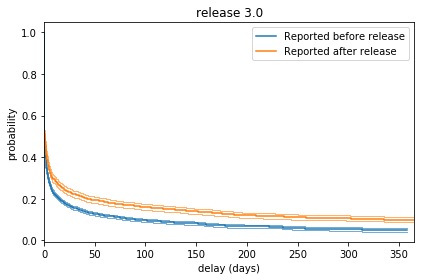

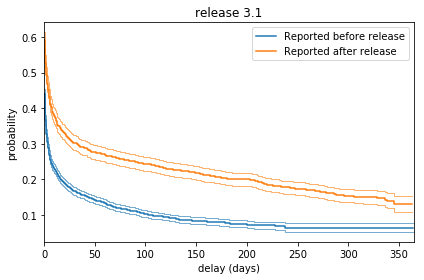

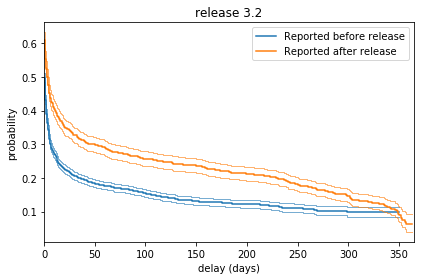

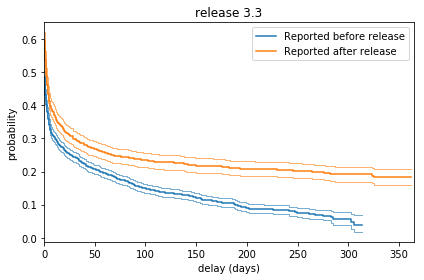

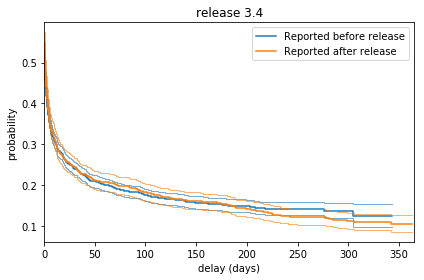

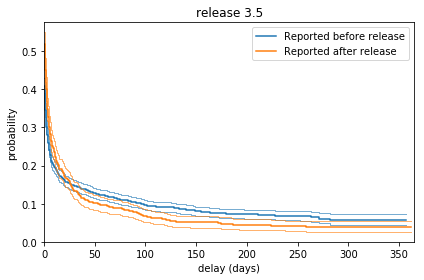

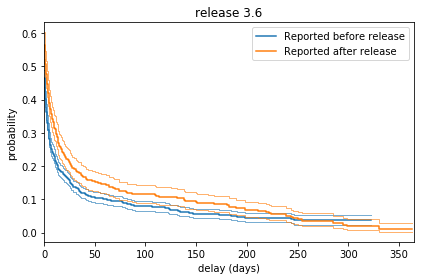

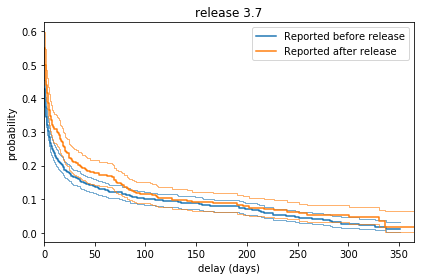

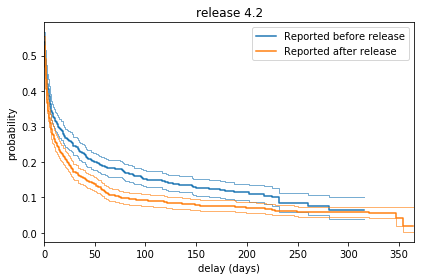

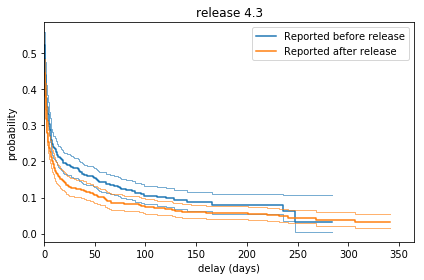

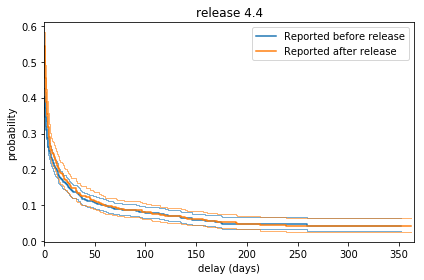

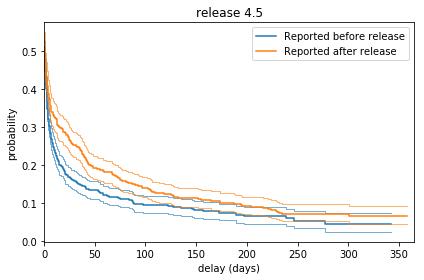

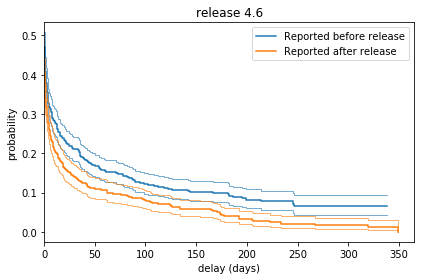

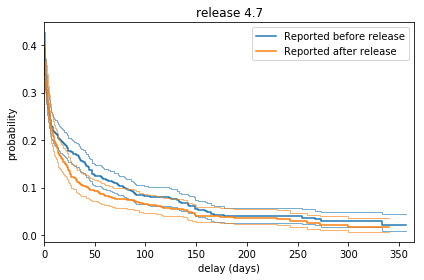

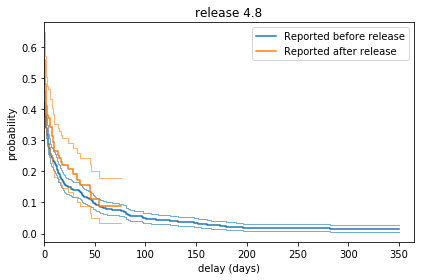

In [45]:
kmf = KaplanMeierFitter()
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)
time=['Reported before release','Reported after release']

for release in RBAB.release.unique():
    ax = plt.subplot(1, 1,1)
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T = dat["triaging_time"]
            E = dat["done"]
            kmf.fit( T, E, label=time[j-1])
            kmf.plot(ax=ax, ci_force_lines=True)
            ax.set_xlabel("delay (days)")
            ax.set_ylabel("probability")
 
    plt.title('release '+version)
    plt.xlim(0, 365)

    plt.savefig('../paper/temp_figs/rq2t_'+version.replace('.', '_')+'.pdf')
    
    plt.tight_layout( )
    plt.show()


In [46]:
#logrank test

In [47]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)

pData=pd.DataFrame()
T=[None] * 2
E=[None] * 2
results=[None] * 7
for release in RBAB.release.unique():
    i=0
    
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    k=0
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T[k] = dat["triaging_time"]
            E[k] = dat["done"]
            k=k+1
    results[i] = logrank_test(T[0], T[1], E[0], E[1], alpha=.95).p_value
    pDat=pd.DataFrame({'version': [release] , 'p':[results[i]] })

    #print(version)
    pData=pData.append(pDat)
 


In [48]:
pData= pData[['version' , 'p']]
pData

,version,p
0,3.0,1.725265e-16
0,3.1,7.282718e-49
0,3.2,9.228699e-23
0,3.3,1.957731e-16
0,3.4,8.328772e-01
0,3.5,4.563037e-01
0,3.6,9.452430e-05
0,3.7,8.346436e-03
0,4.2,9.533547e-05
0,4.3,2.994975e-03


In [49]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')

In [50]:
pData

,version,p,H0
0,3.0,1.725265e-16,reject H0
0,3.1,7.282718e-49,reject H0
0,3.2,9.228699e-23,reject H0
0,3.3,1.957731e-16,reject H0
0,3.4,8.328772e-01,can not reject H0
0,3.5,4.563037e-01,can not reject H0
0,3.6,9.452430e-05,reject H0
0,3.7,8.346436e-03,reject H0
0,4.2,9.533547e-05,reject H0
0,4.3,2.994975e-03,reject H0


In [51]:
pData.to_csv('data'+os.sep+'RQ2'+os.sep+'logrank_test-v2.csv',index=False)

# rolling release

In [52]:
      temp_rolling={  "4.9"  : "2018-09-19 00:00:00",
        "4.10" : "2018-12-19 00:00:00",
        "4.11" : "2019-03-20 00:00:00"}

In [53]:
def get_triaging_statistics_per_release_rolling(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        resolve_column = 'first_resolved_date'
    else:
        resolve_column = 'last_resolved_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        
        end_date_before=addYears(start_date,-1)
        end_date_after=datetime.strptime(temp_rolling[version_successor_rolling(version)], '%Y-%m-%d %H:%M:%S')

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column] > start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0)  &  (version_bugs[assingment_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0) &  (version_bugs[assingment_column] > end_date_after )]
        )

 #& (version_bugs[assingment_column] < end_date_after)
     
        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA = bugs_created_before_assigned_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        RANA = bugs_created_after_release_not_assigned.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)
    return df_ret

In [54]:
tfile = 'data'+os.sep+'RQ2'+os.sep+'rolling_releases_yearly_stats_first_assign-v2.csv'
if not os.path.exists(tfile):
    df_yearly_stats_first_rolling = get_triaging_statistics_per_release_rolling(df_rolling,assignedFirst=True,resolvedFirst=False)
    df_yearly_stats_first_rolling.to_csv(tfile,index=False)
else:
    df_yearly_stats_first_rolling = pd.read_csv(tfile,index_col=False,
                                       dtype={'version': str,'release':str})
    df_yearly_stats_first_rolling["RAAA"]  = df_yearly_stats_first_rolling["RAAA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBAA"]  = df_yearly_stats_first_rolling["RBAA"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RBAB"]  = df_yearly_stats_first_rolling["RBAB"].apply(ast.literal_eval)
    df_yearly_stats_first_rolling["RANA"]  = df_yearly_stats_first_rolling["RANA"].apply(ast.literal_eval)
    
df_yearly_stats_first_rolling['version'] = df_yearly_stats_first_rolling['version'].astype(str)
df_yearly_stats_first_rolling = sort_df(df_yearly_stats_first_rolling,'version')
df_yearly_stats_first_rolling.head()

,version,RAAA,RANA,RBAA,RBAB,after_release,before_release,total
0,4.9,"[539232, 539274, 539308, 539331, 539392, 53940...","[539414, 539706, 539707, 539869, 540817, 54247...","[539191, 536193, 537642, 538199, 538240, 53838...","[535977, 535992, 536027, 536168, 536185, 53620...",341.0,392.0,791.0
1,4.10,"[542946, 543219, 543245, 543609, 543629, 54364...",[],"[540478, 540482, 541232, 541473, 541862, 54254...","[540097, 540200, 540260, 540474, 540580, 54069...",179.0,389.0,572.0


In [56]:
#traiging_time_RBAB=pd.DataFrame()
traiging_time_RB=pd.DataFrame()
traiging_time_RA=pd.DataFrame()
for index, row in df_yearly_stats_first_rolling.iterrows():
    #the bug created and assigned & before release  
   # print(type(row['RBAB']))
   # print(row['RBAB'])
    release=str(row['version'])
    
    #print(release)
    df_b=df_all[df_all.id.isin(row['RBAB'])]
    #print(len(df_b))
    if len(df_b)>0:
 
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])
        df_b['triaging_time'] =df_b.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '1'
        traiging_time_RB=traiging_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBAA'])]
    if len(df_b)>0:

   
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])

        date=datetime.strptime(release_creation_ts_all[release], '%Y-%m-%d %H:%M:%S')
        df_b['triaging_time'] =df_b.apply(lambda x : (date-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'release' ]]
        df_b['done'] = '0'
        traiging_time_RB=traiging_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAAA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '1'
        traiging_time_RA=traiging_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANA'])]
    if len(df_a)>0:
        date=datetime.strptime(release_creation_ts_all[version_successor_rolling(release)], '%Y-%m-%d %H:%M:%S')

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (date-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'release']]
        df_a['done'] = '0'
        traiging_time_RA=traiging_time_RA.append(df_a)
   
    #
traiging_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RB-v2.csv',index=False)    
traiging_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RA-v2.csv',index=False)

4.9
113


C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

4.10
115


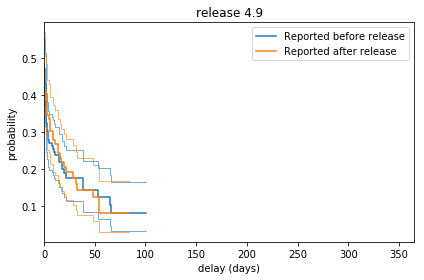

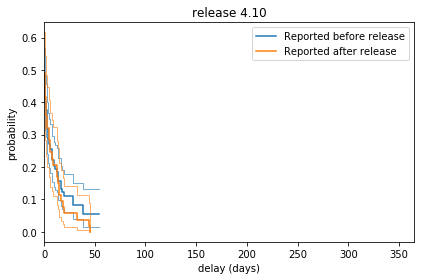

In [57]:
kmf = KaplanMeierFitter()
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)
time=['Reported before release','Reported after release']

for release in RBAB.release.unique():
    ax = plt.subplot(1, 1,1)
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T = dat["triaging_time"]
            E = dat["done"]
            kmf.fit( T, E, label=time[j-1])
            kmf.plot(ax=ax, ci_force_lines=True)
            ax.set_xlabel("delay (days)")
            ax.set_ylabel("probability")
 
    plt.title('release '+version)
    plt.xlim(0, 365)

    plt.savefig('../paper/temp_figs/rq2t_'+version.replace('.', '_')+'.pdf')
    
    plt.tight_layout( )
    plt.show()


In [58]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'rolling_Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['release'] = RBAB['release'].astype(str)
RAAA['release'] = RAAA['release'].astype(str)

pData=pd.DataFrame()
T=[None] * 2
E=[None] * 2
results=[None] * 7
for release in RBAB.release.unique():
    i=0
    
    file=[release,RBAB[RBAB['release']==release],RAAA[RAAA['release']==release]]
    k=0
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T[k] = dat["triaging_time"]
            E[k] = dat["done"]
            k=k+1
    results[i] = logrank_test(T[0], T[1], E[0], E[1], alpha=.95).p_value
    pDat=pd.DataFrame({'version': [release] , 'p':[results[i]] })

    #print(version)
    pData=pData.append(pDat)
 


In [59]:
pData= pData[['version' , 'p']]
pData

,version,p
0,4.9,0.862668
0,4.10,0.499516


In [60]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')

In [61]:
pData

,version,p,H0
0,4.9,0.862668,can not reject H0
0,4.10,0.499516,can not reject H0


# Severity stats

In [62]:
all_releases = ["3.0",
    "3.1",
    "3.2", #Callisto
    "3.3", #Europa
    "3.4", #Ganymede
    "3.5", #Galileo
    "3.6", #Helios
    "3.7", #Indigo
    "4.2", #Juno

    "4.3", #Kepler
    "4.4", #Luna
    "4.5", #Mars
    "4.6", #Neon
    "4.7", #Oxygen
    "4.8", #Photon
                    "4.9" ,#Photon
                    "4.10" ,#Photon
                    "4.11" #Photon
    ]
list_sev=['trivial','minor','normal',  'major', 'critical', 'blocker']
def version_successor_all(release):

    return all_releases[all_releases.index(release)+1]
   
def version_predecessor(release):
    return all_releases[all_releases.index(release)-1]    

In [63]:
def get_triaging_statistics_per_release(df_w,assignedFirst,resolvedFirst):
    #Calculate traiging time per release
    df_ret=pd.DataFrame()
    df_w['release'] = df_w['release'].astype(str)
    
    if assignedFirst:
        assingment_column = 'first_assignment_date'
    else:
        assingment_column = 'last_assignment_date'
        
        
    if resolvedFirst:
        resolve_column = 'first_resolved_date'
    else:
        resolve_column = 'last_resolved_date'
        
        
    for version in df_w.release.unique():
        start_date = release_creation_ts_all[version]
        start_date = pd.to_datetime(start_date)
        if version=='3.0':
            end_date_before=addYears(start_date,-1)
            
            #print(release_creation_ts_all[version_successor(version)])
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor(version)], '%Y-%m-%d %H:%M:%S')
        else:
            end_date_before=datetime.strptime(release_creation_ts_all[version_predecessor(version)], '%Y-%m-%d %H:%M:%S')
            end_date_after=datetime.strptime(release_creation_ts_all[version_successor_all(version)], '%Y-%m-%d %H:%M:%S')                
        
       # print('version: ',version, 'start_date: ',start_date,'end_date_before: ',end_date_before,'end_date_after: ',end_date_after)

        #Fetch the bugs of this version
        version_bugs = df_w[df_w['release']==version]
        version_bugs = trans_to_datetime(version_bugs,
                                        ['creation_time','first_assignment_date',
       'last_assignment_date', 'first_resolved_date', 'last_resolved_date',
       'first_fixed_date', 'last_fixed_date'])

        #the bug before release 
        bugs_before_release = version_bugs[(version_bugs['creation_time']<start_date) & (version_bugs['creation_time']>=end_date_before) ]
        
        #the bug after release 
        bugs_after_release = version_bugs[(version_bugs['creation_time']>= start_date) & (version_bugs['creation_time']< end_date_after)]
        
        #the bug created and assigned & before release 
        bugs_created_assigned_before_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column]<start_date)]
        )   
   

        #the bug created before release and assigned  after release 
        bugs_created_before_assigned_after_release = (
            version_bugs[(version_bugs['id'].isin(bugs_before_release.id.unique())) &
                        (version_bugs[assingment_column] >= start_date )]
        )



        #the bug created after release  and assigned
        bugs_created_after_release_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0)  &  (version_bugs[assingment_column] <= end_date_after )]
        )
                #the bug created after release  and assigned
        bugs_created_after_release_not_assigned = (
            version_bugs[(version_bugs['id'].isin(bugs_after_release.id.unique())) &
                        (version_bugs['is_assigned'] > 0) &  (version_bugs[assingment_column] > end_date_after )]
        )

 #& (version_bugs[assingment_column] < end_date_after)
     
        before_release = len(bugs_before_release.id.unique())
        RBAB= bugs_created_assigned_before_release.id.unique().tolist()
        RBAA =  bugs_created_before_assigned_after_release.id.unique().tolist()
        after_release = len(bugs_after_release.id.unique())
        RAAA = bugs_created_after_release_assigned.id.unique().tolist()
        RANA = bugs_created_after_release_not_assigned.id.unique().tolist()
       
  
        df_ret=df_ret.append({"version": version , 
                           "total": len(version_bugs.id.unique()) ,
                           'before_release': before_release, 
                           'after_release':after_release, 
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)
    return df_ret

In [64]:
df_all.release.unique()

array(['4.5', '4.6', '4.4', '3.7', '4.2', '4.3', '3.6', '4.8', '3.1',
       '4.7', '4.10', '3.4', '3.5', '3.3', '3.2', '3.0', '4.9'],
      dtype=object)

In [65]:
df_stat = get_triaging_statistics_per_release(df_all,assignedFirst=True,resolvedFirst=False)

In [66]:
RAAA=[]
RANA=[]
RBAA=[]
RBAB=[]
severity_stat=pd.DataFrame()
for index, row in df_stat.iterrows():
   # x=severity_stat[severity_stat['version']==version]
 #   print(len(row['RAAA']))
    RAAA=RAAA+row['RAAA']
    RANA=RANA+row['RANA']
    RBAA=RBAA+row['RBAA']
    RBAB=RBAB+row['RBAB']

severity_stat=severity_stat.append({
                           'RBAB':RBAB, 
                           'RBAA':RBAA, 
                           'RAAA':RAAA,
                           'RANA':RANA
                            },ignore_index=True)    

In [67]:
severity_stat

,RAAA,RANA,RBAA,RBAB
0,"[475775, 475785, 475839, 475858, 475934, 47599...","[476644, 477965, 478336, 478634, 478941, 47916...","[465893, 465911, 466075, 466314, 466500, 46673...","[465868, 465972, 466080, 466114, 466230, 46623..."


In [68]:
d = {'severity':['trivial','minor','normal',  'major', 'critical', 'blocker'], 'RAAA': [[],[],[],[],[],[]], 'RANA': [[],[],[],[],[],[]], 'RBAA': [[],[],[],[],[],[]], 'RBAB': [[],[],[],[],[],[]]}
df_severity= pd.DataFrame(data=d)

for index, row in severity_stat.iterrows():
   # x=severity_stat[severity_stat['version']==version]
    #RAAA=RAAA+row['RAAA']
    dfr=df_all[df_all.id.isin(row['RAAA'])]
    print(dfr.severity.unique())
    for index1, row1 in dfr.iterrows():
        df_severity.loc[df_severity.severity==row1['severity'], 'RAAA'] = df_severity.loc[df_severity.severity==row1['severity'], 'RAAA']+[row1['id']]
   
    dfr=df_all[df_all.id.isin(row['RANA'])]
    print(dfr.severity.unique())
    for index1, row1 in dfr.iterrows():
        df_severity.loc[df_severity.severity==row1['severity'], 'RANA'] = df_severity.loc[df_severity.severity==row1['severity'], 'RANA']+[row1['id']]

    dfr=df_all[df_all.id.isin(row['RBAA'])]
    print(dfr.severity.unique())
    for index1, row1 in dfr.iterrows():
        df_severity.loc[df_severity.severity==row1['severity'], 'RBAA'] = df_severity.loc[df_severity.severity==row1['severity'], 'RBAA']+[row1['id']]
    dfr=df_all[df_all.id.isin(row['RBAB'])]
    print(dfr.severity.unique())
    for index1, row1 in dfr.iterrows():
        df_severity.loc[df_severity.severity==row1['severity'], 'RBAB'] = df_severity.loc[df_severity.severity==row1['severity'], 'RBAB']+[row1['id']]



['minor' 'normal' 'major' 'critical' 'trivial' 'blocker']
['normal' 'critical' 'blocker' 'minor' 'trivial' 'major']
['normal' 'major' 'minor' 'trivial' 'critical' 'blocker']
['normal' 'major' 'blocker' 'critical' 'minor' 'trivial']


In [69]:
df_severity

,severity,RAAA,RANA,RBAA,RBAB
0,trivial,"[245877, 104342, 367105, 283555, 284556, 28503...","[244965, 103202, 289346, 110584, 108693, 10870...","[250427, 101468, 101933, 143540, 145015, 64830...","[245845, 245846, 245849, 245850, 245854, 24669..."
1,minor,"[475775, 477471, 479727, 244623, 245514, 24734...","[244409, 248612, 183675, 186988, 102297, 10524...","[248135, 250176, 184280, 184656, 185932, 18623...","[482501, 247435, 247945, 183975, 183976, 18417..."
2,normal,"[475785, 475839, 475858, 475934, 475992, 47611...","[476644, 477965, 478336, 478941, 479162, 48000...","[475658, 475659, 475784, 477979, 480563, 48114...","[475604, 475643, 475647, 475649, 475650, 47565..."
3,major,"[476043, 478975, 481611, 482022, 244652, 24552...","[245766, 184413, 185561, 102888, 116246, 11625...","[480954, 481814, 183963, 184261, 184924, 18551...","[476215, 480342, 245724, 246092, 247557, 24763..."
4,critical,"[479435, 244597, 245159, 245367, 246593, 24839...","[478634, 119156, 269121, 538377, 538752, 46069...","[185705, 100835, 374199, 44438, 484506, 146916...","[480261, 247133, 184922, 186419, 187168, 18789..."
5,blocker,"[246057, 246309, 103361, 103894, 104748, 10520...","[480852, 490026, 399786, 533475, 537934, 69620...","[145890, 463531, 68353, 100666, 374777, 495598...","[479233, 479980, 480318, 184589, 185087, 18509..."


In [70]:
#traiging_time_RBAB=pd.DataFrame()
traiging_time_RB=pd.DataFrame()
traiging_time_RA=pd.DataFrame()
for index, row in df_severity.iterrows():
    #the bug created and assigned & before release  
   # print(type(row['RBAB']))
   # print(row['RBAB'])
    sev=str(row['severity'])
    
    df_b=df_all[df_all.id.isin(row['RBAB'])]
    if len(df_b)>0:
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])
        df_b['triaging_time'] =df_b.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'severity','release' ]]
        df_b['done'] = '1'
        traiging_time_RB=traiging_time_RB.append(df_b)
    #the bug created before and assigned after release  
    df_b=df_all[df_all.id.isin(row['RBAA'])]
    if len(df_b)>0:
   
        df_b=trans_to_datetime(df_b,['creation_time','first_assignment_date'])

        df_b['triaging_time'] =df_b.apply(lambda x : (datetime.strptime(release_creation_ts_all[x['release']], '%Y-%m-%d %H:%M:%S')-x['creation_time']).days, axis=1)
        df_b= df_b[['id',
         'first_assignment_date',
         'triaging_time' ,'severity' ,'release']]
        df_b['done'] = '0'
        traiging_time_RB=traiging_time_RB.append(df_b)
    
    
    #the bug created and assigned & after release 
    df_a=df_all[df_all.id.isin(row['RAAA'])]
    if len(df_a)>0:

        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (x['first_assignment_date']-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'severity','release']]
        df_a['done'] = '1'
        traiging_time_RA=traiging_time_RA.append(df_a)
     #the bug created after release and not assigned within 1 year
    df_a=df_all[df_all.id.isin(row['RANA'])]
    if len(df_a)>0:
        df_a=trans_to_datetime(df_a,['creation_time','first_assignment_date']) 
        df_a['triaging_time'] =df_a.apply(lambda x : (datetime.strptime(release_creation_ts_all[version_successor_all(x['release'])], '%Y-%m-%d %H:%M:%S')-x['creation_time']).days, axis=1)

        df_a= df_a[['id',
         'first_assignment_date',
         'triaging_time',
            'severity','release']]
        df_a['done'] = '0'
        traiging_time_RA=traiging_time_RA.append(df_a)
   
    #
traiging_time_RB.to_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RB-v2.csv',index=False)    
traiging_time_RA.to_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RA-v2.csv',index=False)

C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\zeinab\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable

In [ ]:
RBAB.groupby('severity').agg({'id':'count'})
RAAA.groupby('severity').agg({'id':'count'})

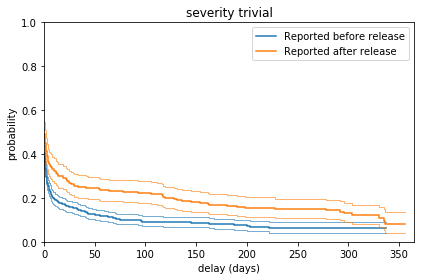

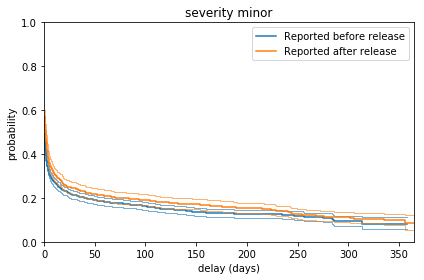

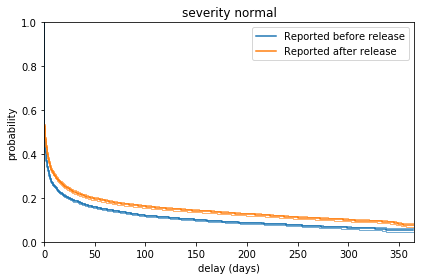

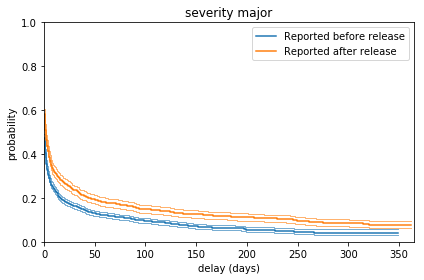

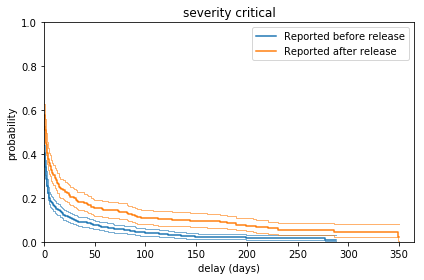

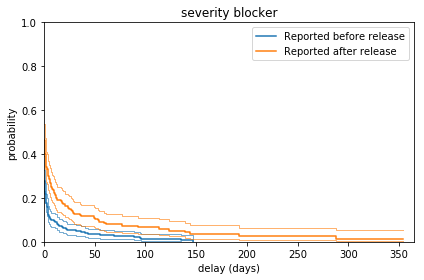

In [71]:
kmf = KaplanMeierFitter()
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['severity'] = RBAB['severity'].astype(str)
RAAA['severity'] = RAAA['severity'].astype(str)
time=['Reported before release','Reported after release']

for severityy in list_sev:
    ax = plt.subplot(1, 1,1)
    file=[severityy,RBAB[RBAB['severity']==severityy],RAAA[RAAA['severity']==severityy]]
    
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T = dat["triaging_time"]
            E = dat["done"]
            kmf.fit( T, E, label=time[j-1])
            kmf.plot(ax=ax, ci_force_lines=True)
            ax.set_xlabel("delay (days)")
            ax.set_ylabel("probability")
 
    plt.title('severity '+version)
    plt.xlim(0, 365)
    plt.ylim(0, 1)

    #plt.savefig('../paper/temp_figs/rq2t_'+version.replace('.', '_')+'.pdf')
    
    plt.tight_layout( )
    plt.show()

In [83]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['severity'] = RBAB['severity'].astype(str)
RAAA['severity'] = RAAA['severity'].astype(str)

pData=pd.DataFrame()
T=[None] * 2
E=[None] * 2
results=[None] * 7
for severityy in list_sev:
    i=0
    
    file=[severityy,RBAB[RBAB['severity']==severityy],RAAA[RAAA['severity']==severityy]]
    k=0
    for j,dat in enumerate(file):
        if j==0:
            version=dat
        else:
            T[k] = dat["triaging_time"]
            E[k] = dat["done"]
            k=k+1
    results[i] = logrank_test(T[0], T[1], E[0], E[1], alpha=.95).p_value
    pDat=pd.DataFrame({'severity': [severityy] , 'p':[results[i]] })

    #print(version)
    pData=pData.append(pDat)
 


In [84]:
pData= pData[['severity' , 'p']]
pData

,severity,p
0,trivial,7.019811e-06
0,minor,8.809050e-03
0,normal,4.239032e-36
0,major,1.370474e-13
0,critical,3.453027e-09
0,blocker,3.659832e-06


In [85]:
pData['H0'] = pData['p'].apply(lambda x: 'reject H0' if x <0.01 else 'can not reject H0')
pData

,severity,p,H0
0,trivial,7.019811e-06,reject H0
0,minor,8.809050e-03,reject H0
0,normal,4.239032e-36,reject H0
0,major,1.370474e-13,reject H0
0,critical,3.453027e-09,reject H0
0,blocker,3.659832e-06,reject H0


# stat of release and severity 

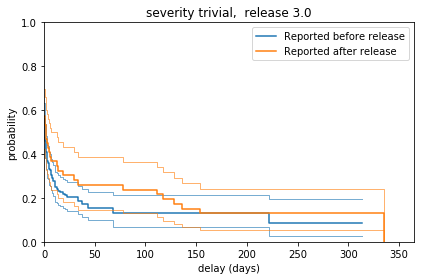

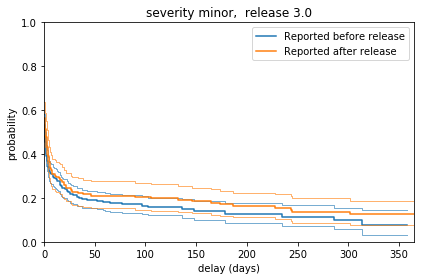

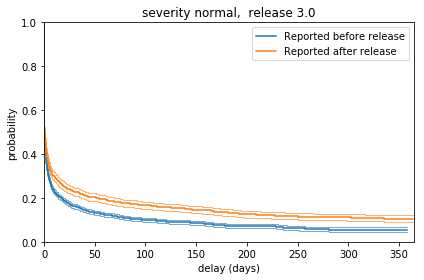

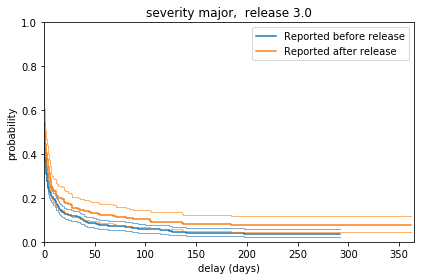

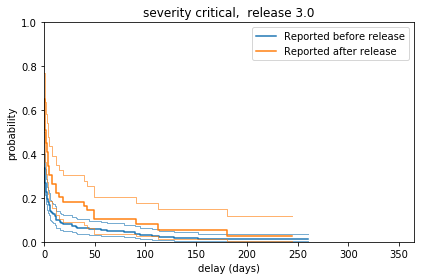

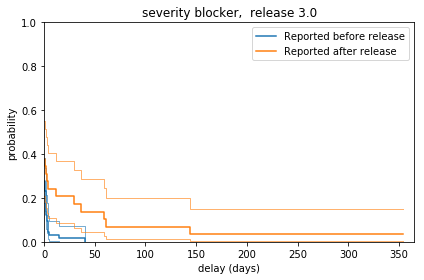

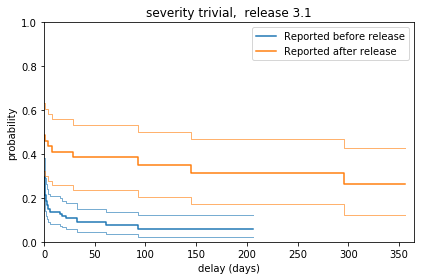

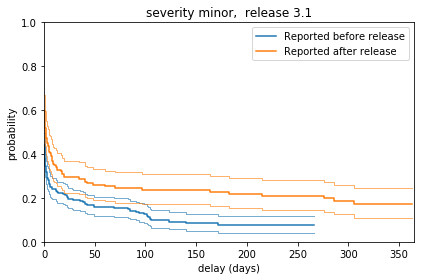

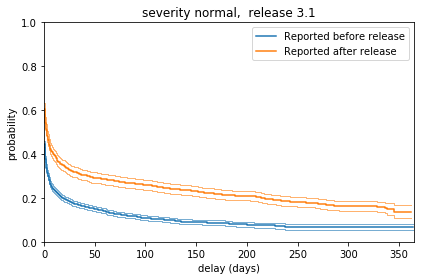

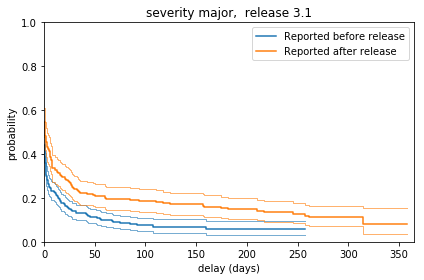

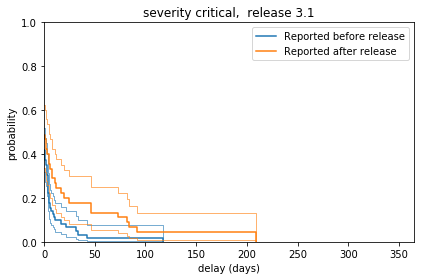

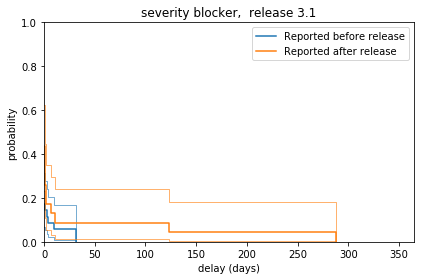

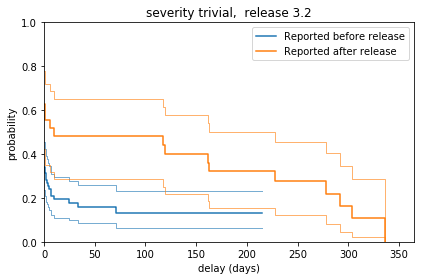

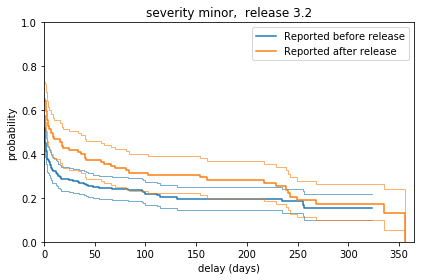

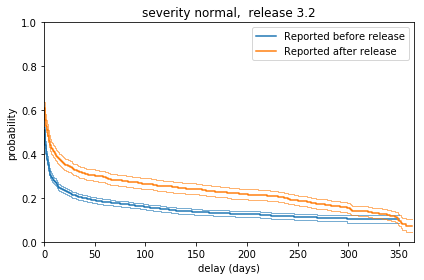

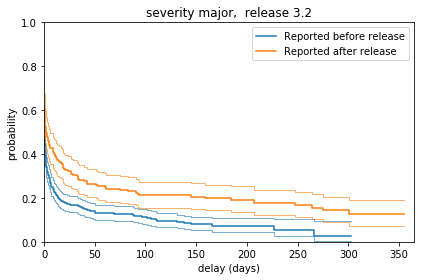

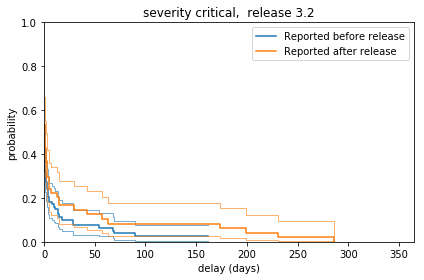

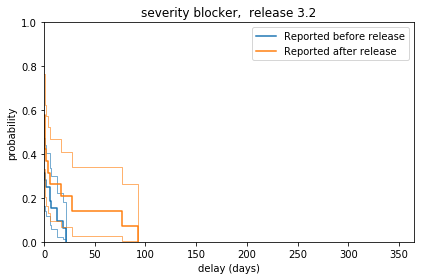

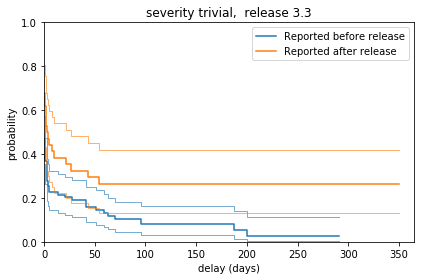

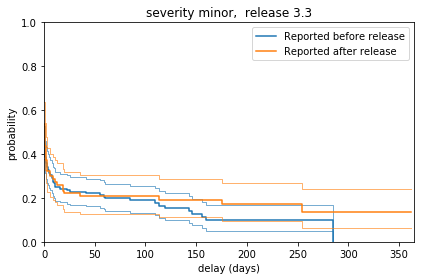

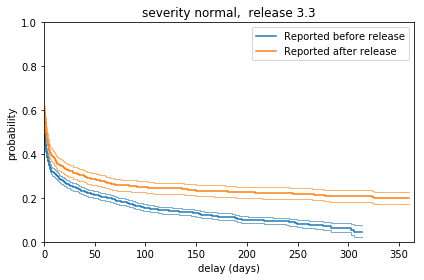

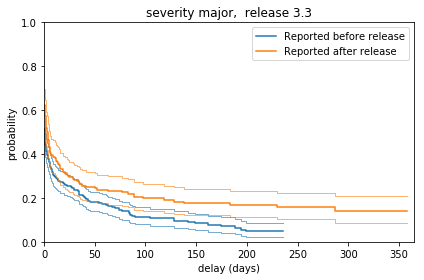

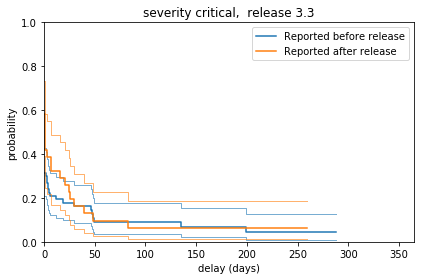

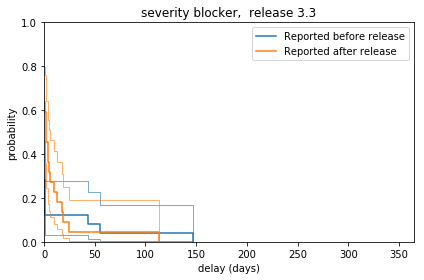

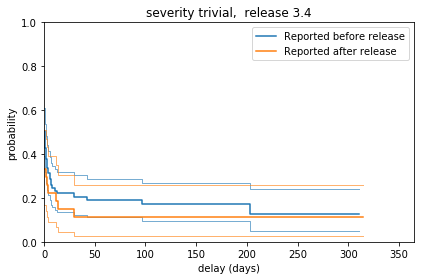

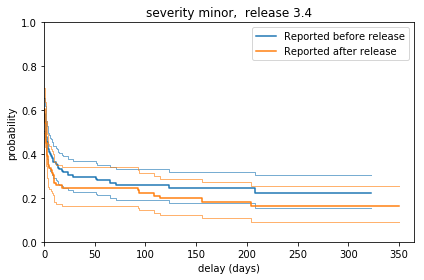

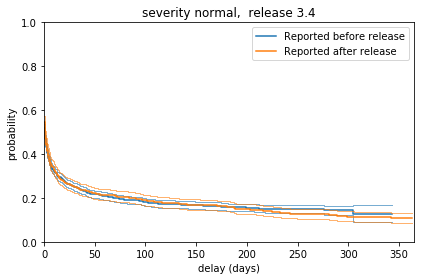

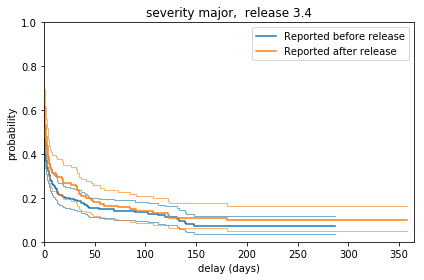

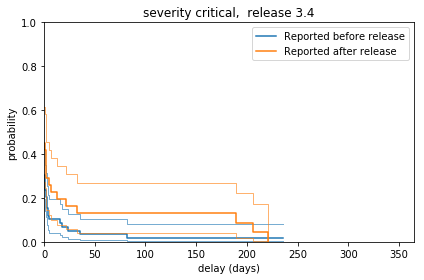

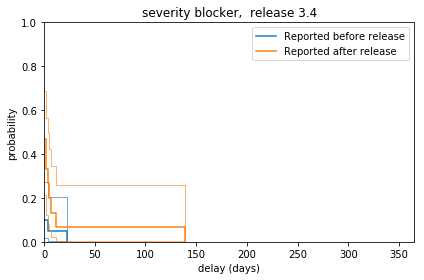

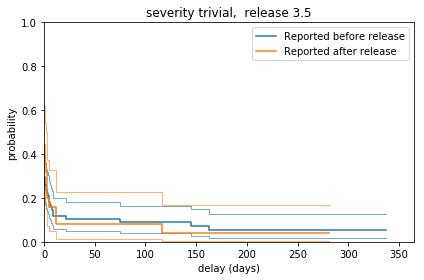

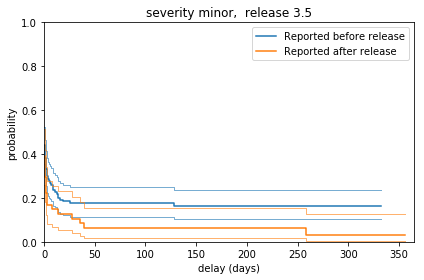

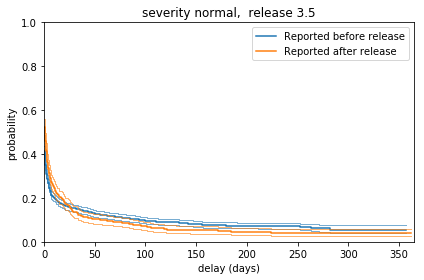

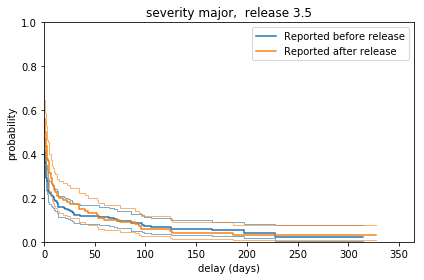

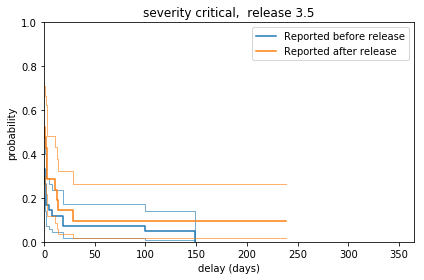

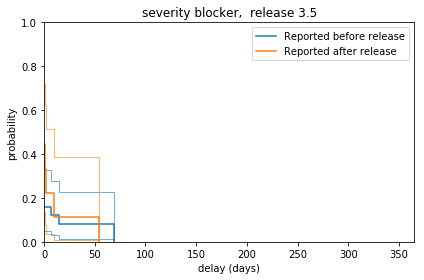

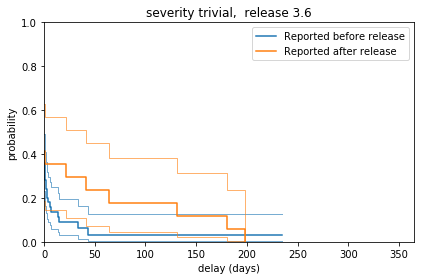

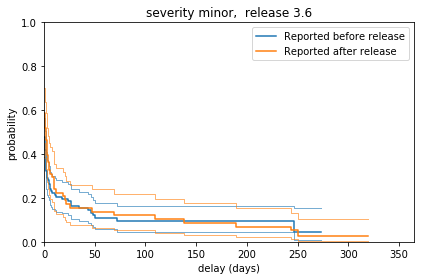

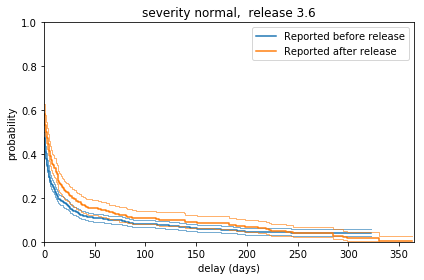

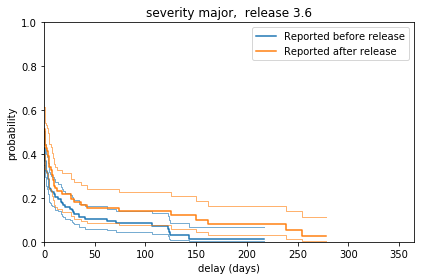

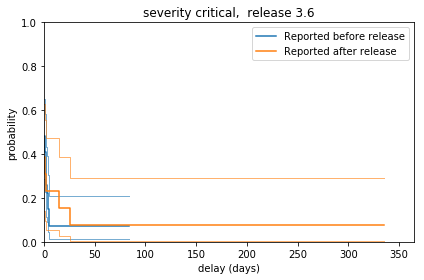

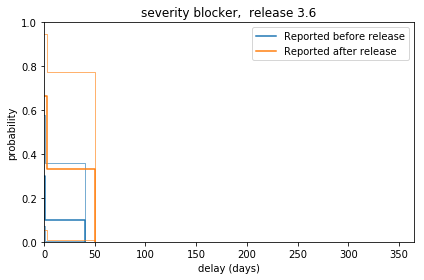

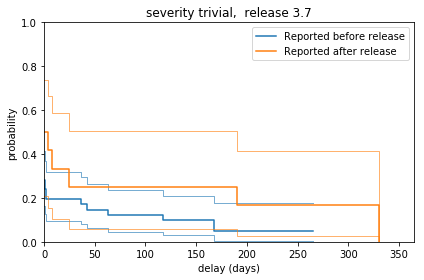

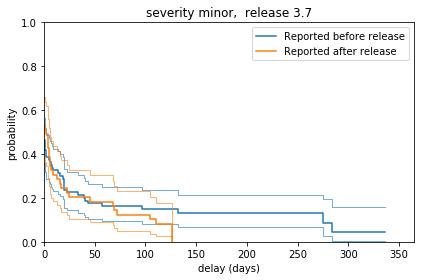

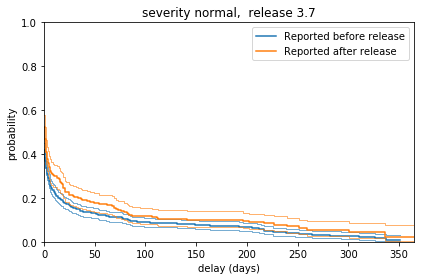

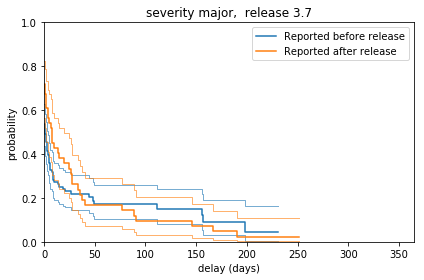

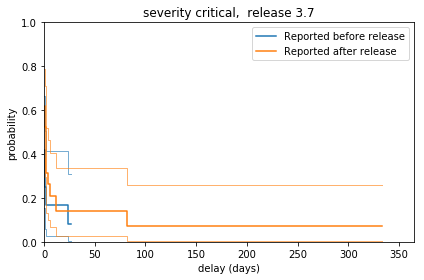

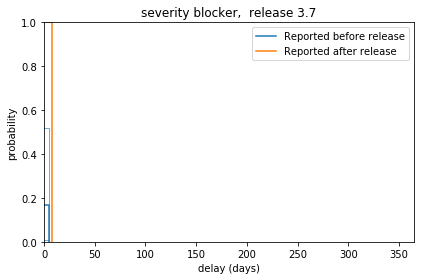

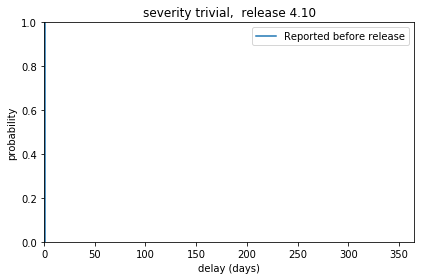

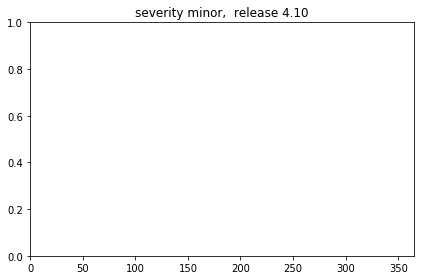

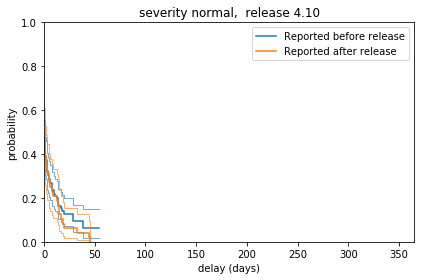

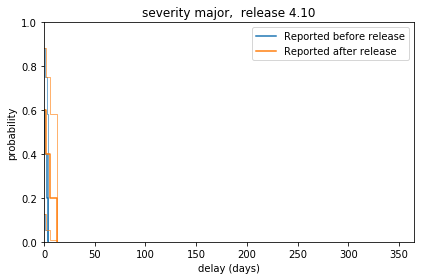

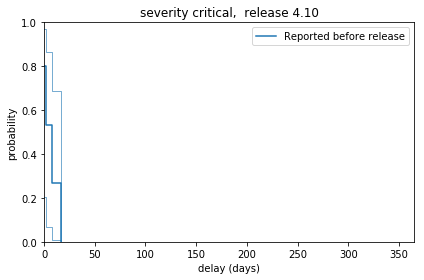

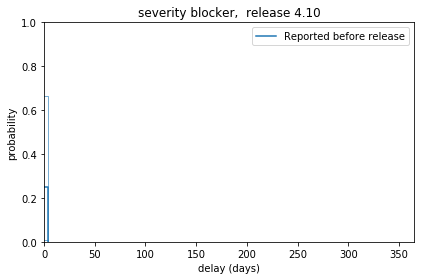

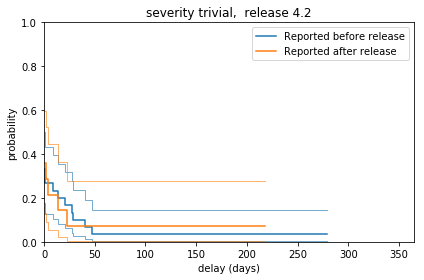

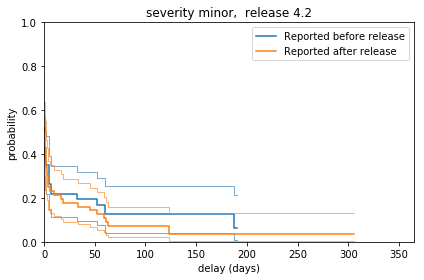

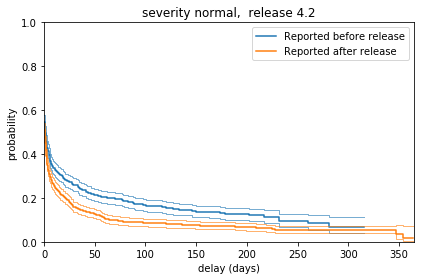

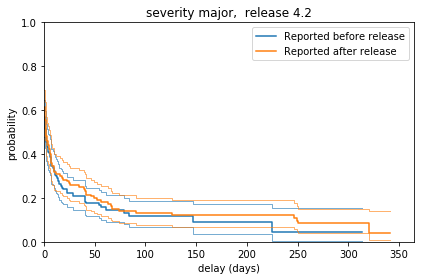

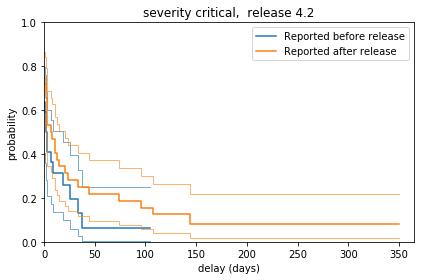

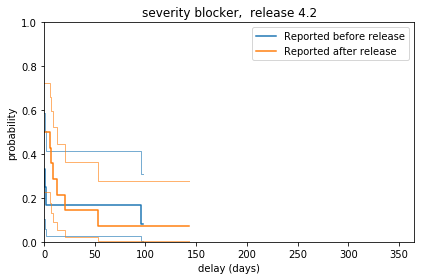

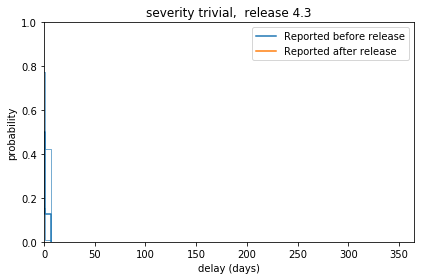

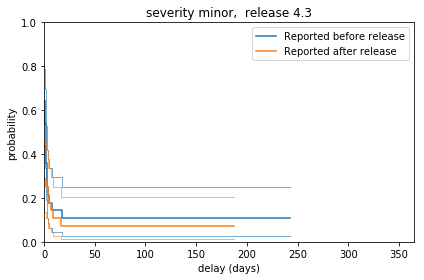

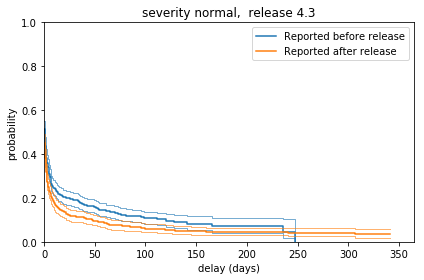

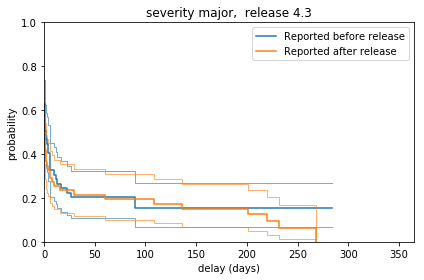

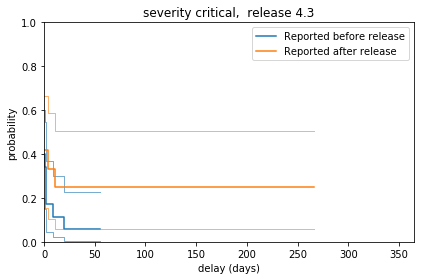

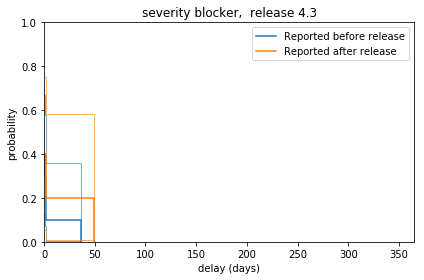

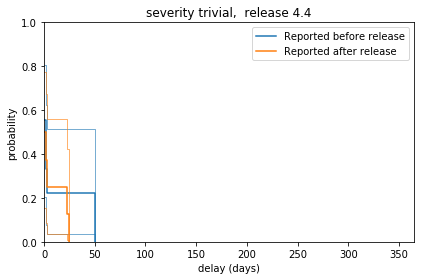

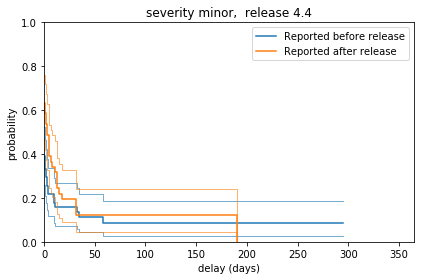

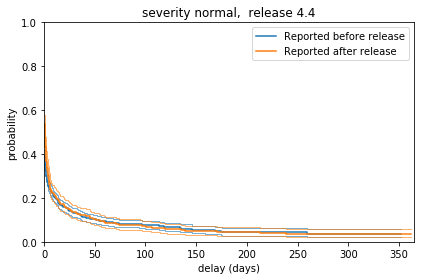

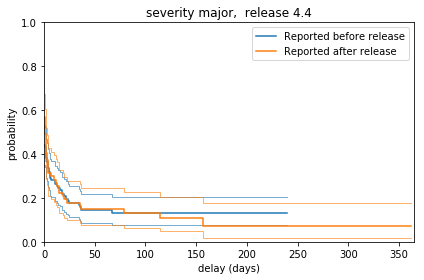

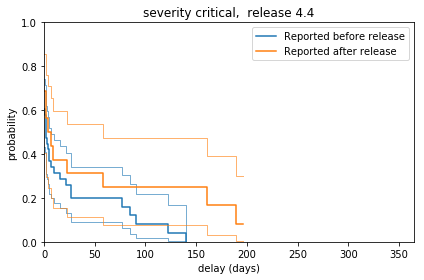

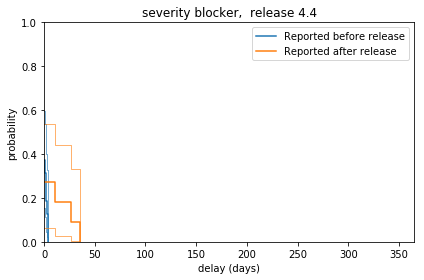

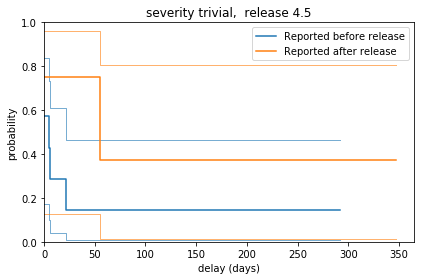

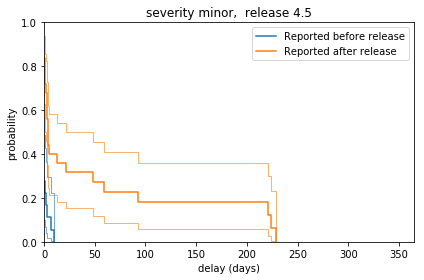

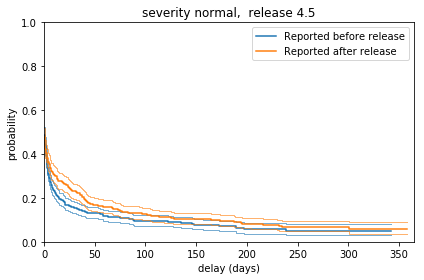

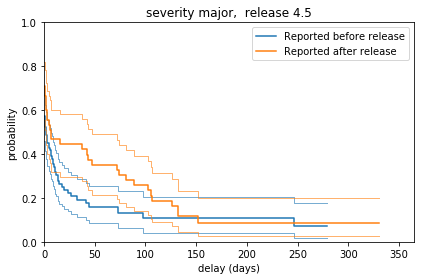

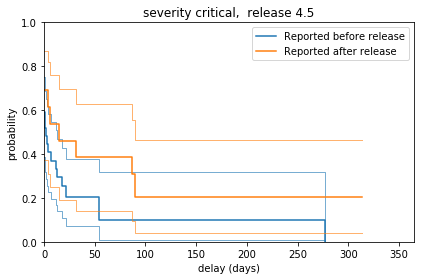

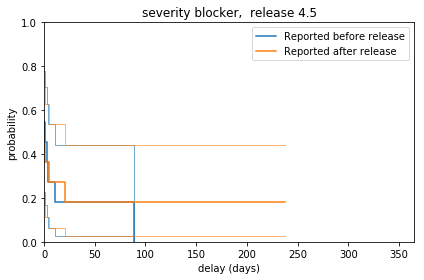

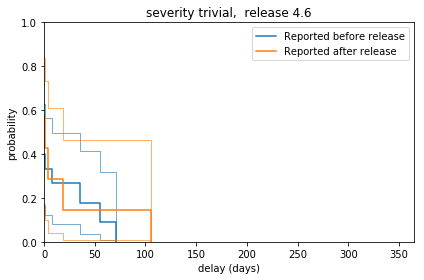

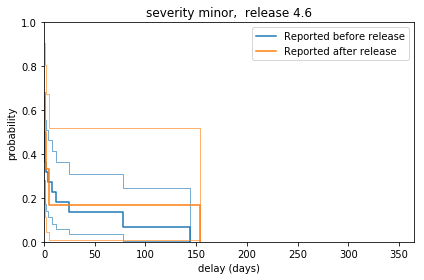

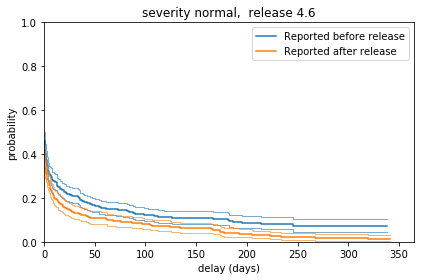

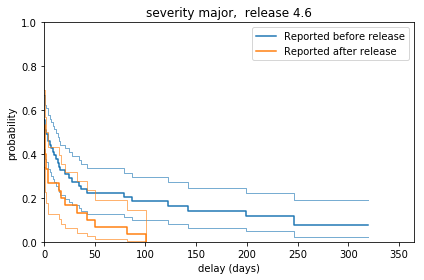

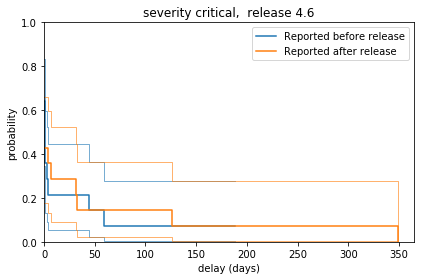

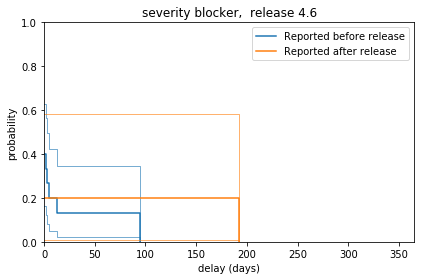

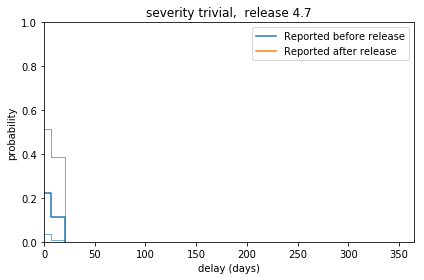

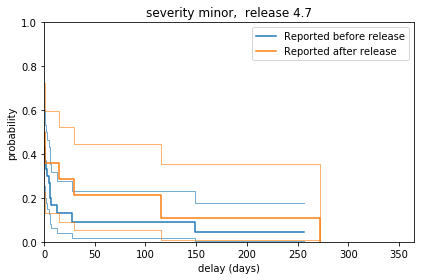

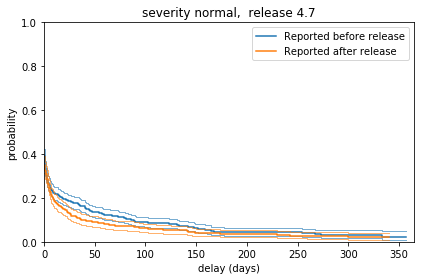

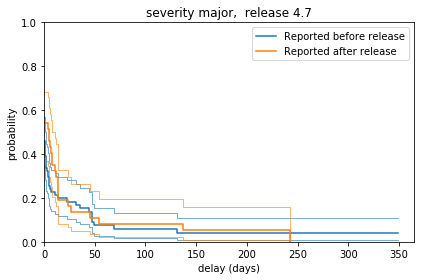

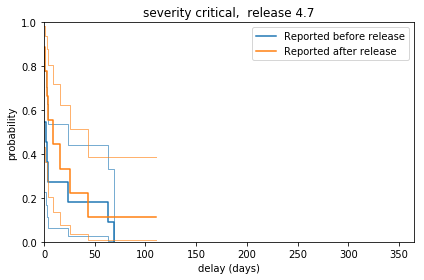

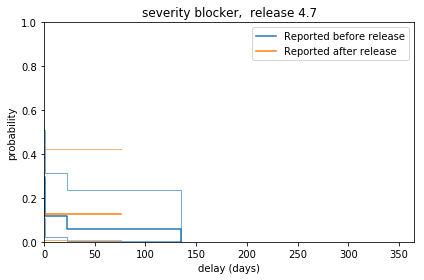

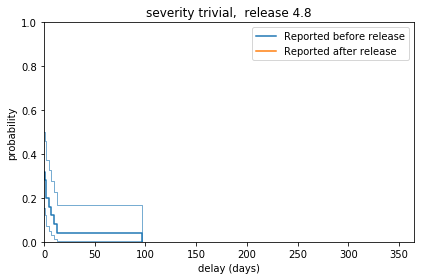

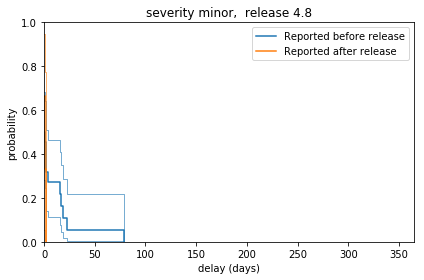

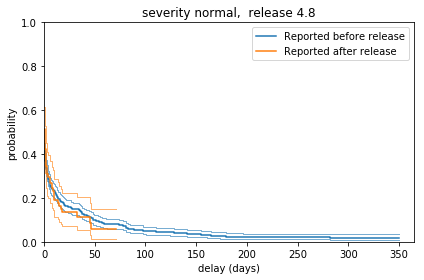

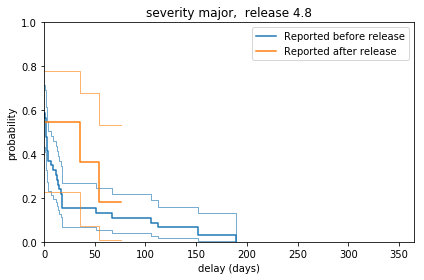

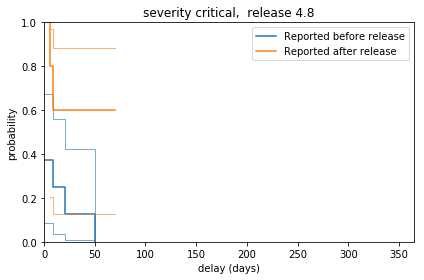

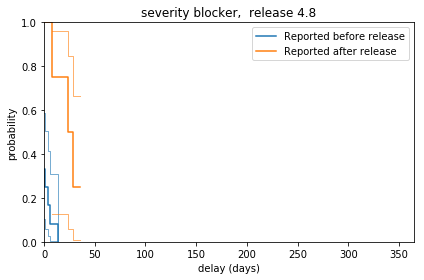

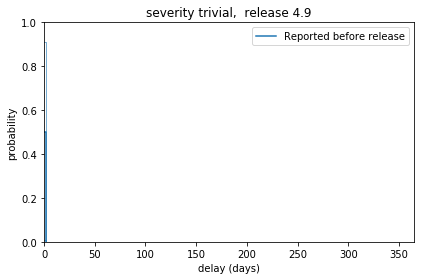

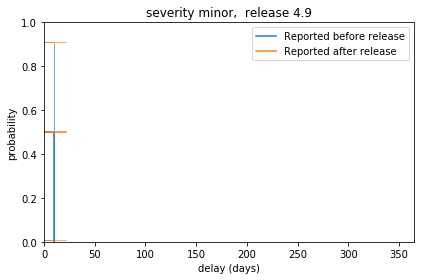

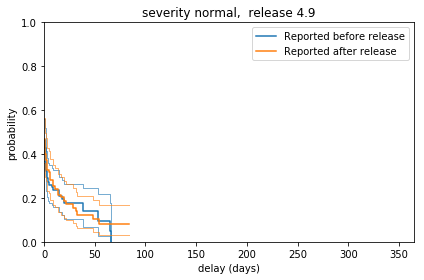

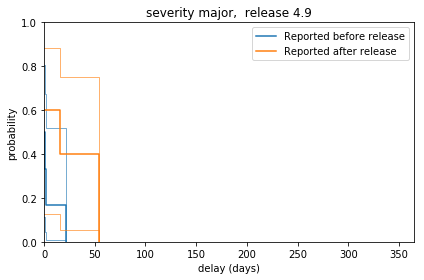

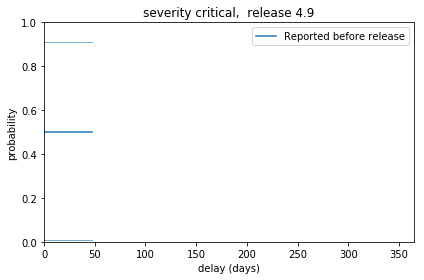

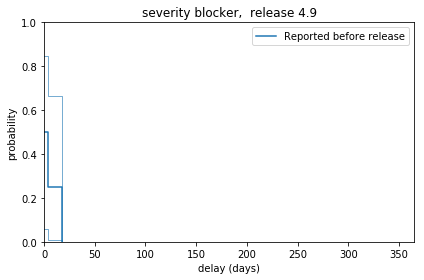

In [72]:
kmf = KaplanMeierFitter()
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['severity'] = RBAB['severity'].astype(str)
RAAA['severity'] = RAAA['severity'].astype(str)
time=['Reported before release','Reported after release']

for release in sorted(RBAB.release.unique().tolist()):
    for severityy in list_sev:
        ax = plt.subplot(1, 1,1)
        
        file=[severityy,RBAB[(RBAB['severity']==severityy) & (RBAB['release']==release)],RAAA[(RAAA['severity']==severityy) & (RAAA['release']==release)]]

        for j,dat in enumerate(file):
            
            if j==0:
                version=dat
            else:
                #if len(dat)>0:
                try:
                    T = dat["triaging_time"]
                    E = dat["done"]
                    kmf.fit( T, E, label=time[j-1])
                    kmf.plot(ax=ax, ci_force_lines=True)
                    ax.set_xlabel("delay (days)")
                    ax.set_ylabel("probability")
                except ValueError:  
                        pass
        plt.title('severity '+version + ',  release '+release)
        plt.xlim(0, 365)
        plt.ylim(0, 1)

    #plt.savefig('../paper/temp_figs/rq2t_'+version.replace('.', '_')+'.pdf')
    
        plt.tight_layout( )
        plt.show()

In [86]:
RBAB = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RB-v2.csv',index_col=False,dtype={'release':str})
RAAA = pd.read_csv('data'+os.sep+'RQ2'+os.sep+'sev-Eclipse-RA-v2.csv',index_col=False,dtype={'release':str})
RBAB['severity'] = RBAB['severity'].astype(str)
RAAA['severity'] = RAAA['severity'].astype(str)

pData=pd.DataFrame()
T=[None] * 2
E=[None] * 2
results=[None] * 7
for release in sorted(RBAB.release.unique().tolist()):
    for severityy in list_sev:
        i=0

        file=[severityy,RBAB[(RBAB['severity']==severityy) & (RBAB['release']==release)],RAAA[(RAAA['severity']==severityy) & (RAAA['release']==release)]]
        k=0
        for j,dat in enumerate(file):
            if j==0:
                version=dat
            else:
                T[k] = dat["triaging_time"]
                E[k] = dat["done"]
                k=k+1
        results[i] = logrank_test(T[0], T[1], E[0], E[1], alpha=.95).p_value
        pDat=pd.DataFrame({'severity': [severityy] , 'p':[results[i]] })

        #print(version)
        pData=pData.append(pDat)
 


UnboundLocalError: local variable 'data' referenced before assignment

In [ ]:
severity_stat=df_stat.copy()
for index, row in severity_stat.iterrows():
   # x=severity_stat[severity_stat['version']==version]
    RAAA=row['RAAA']
    RAAA=df_all[df_all['id'].isin(RAAA)]
    gp_RAAA=RAAA.groupby('severity').agg({'id':'count'})
    
    RANA=row['RANA']
    RANA=df_all[df_all['id'].isin(RANA)]
    gp_RANA=RANA.groupby('severity').agg({'id':'count'})
    
    RBAA=row['RBAA']
    RBAA=df_all[df_all['id'].isin(RBAA)]
    gp_RBAA=RBAA.groupby('severity').agg({'id':'count'})
    
    RBAB=row['RBAB']
    RBAB=df_all[df_all['id'].isin(RBAB)]
    gp_RBAB=RBAB.groupby('severity').agg({'id':'count'})
    
    break
    
    